The panoptic API is required for panoptic inference

In [18]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

import os
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np


In [19]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [20]:
# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
%cd
import os
# 檔案的 URL 和目標路徑
url = "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth"
target_dir = "./cv_final/detr"
filename = "detr-r101-panoptic-40021d53.pth"

# 檢查檔案是否已存在
if not os.path.exists(os.path.join(target_dir, filename)):
    # 如果不存在，則進行下載
    %cd ./cv_final/detr
    !wget https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth
    %cd
    print(f"\n下載完成: {filename}")
else:
    print(f"檔案已存在: {filename}")

/home/leowang707
檔案已存在: detr-r101-panoptic-40021d53.pth


In [22]:
%cd
%cd ./cv_final/detr
from hubconf import detr_resnet101_panoptic  # 确保路径正确

# 创建模型实例
model, postprocessor = detr_resnet101_panoptic(pretrained=False, num_classes=250, return_postprocessor = True)

model_path = 'detr-r101-panoptic-40021d53.pth'  # 预训练权重文件路径

# 加载本地预训练权重
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])

# 设置模型为评估模式
model.eval()

/home/leowang707
/home/leowang707/cv_final/detr


DETRsegm(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
             

In [23]:
%cd
%cd ./cv_final/notebooks
# read from path
path = 'image2.jpg'
im = Image.open(path).convert('RGB')

/home/leowang707
/home/leowang707/cv_final/notebooks


Finally, we run the prediction

In [24]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
out = model(img)

This returns a mask for each query, let us visualize the high confidence ones

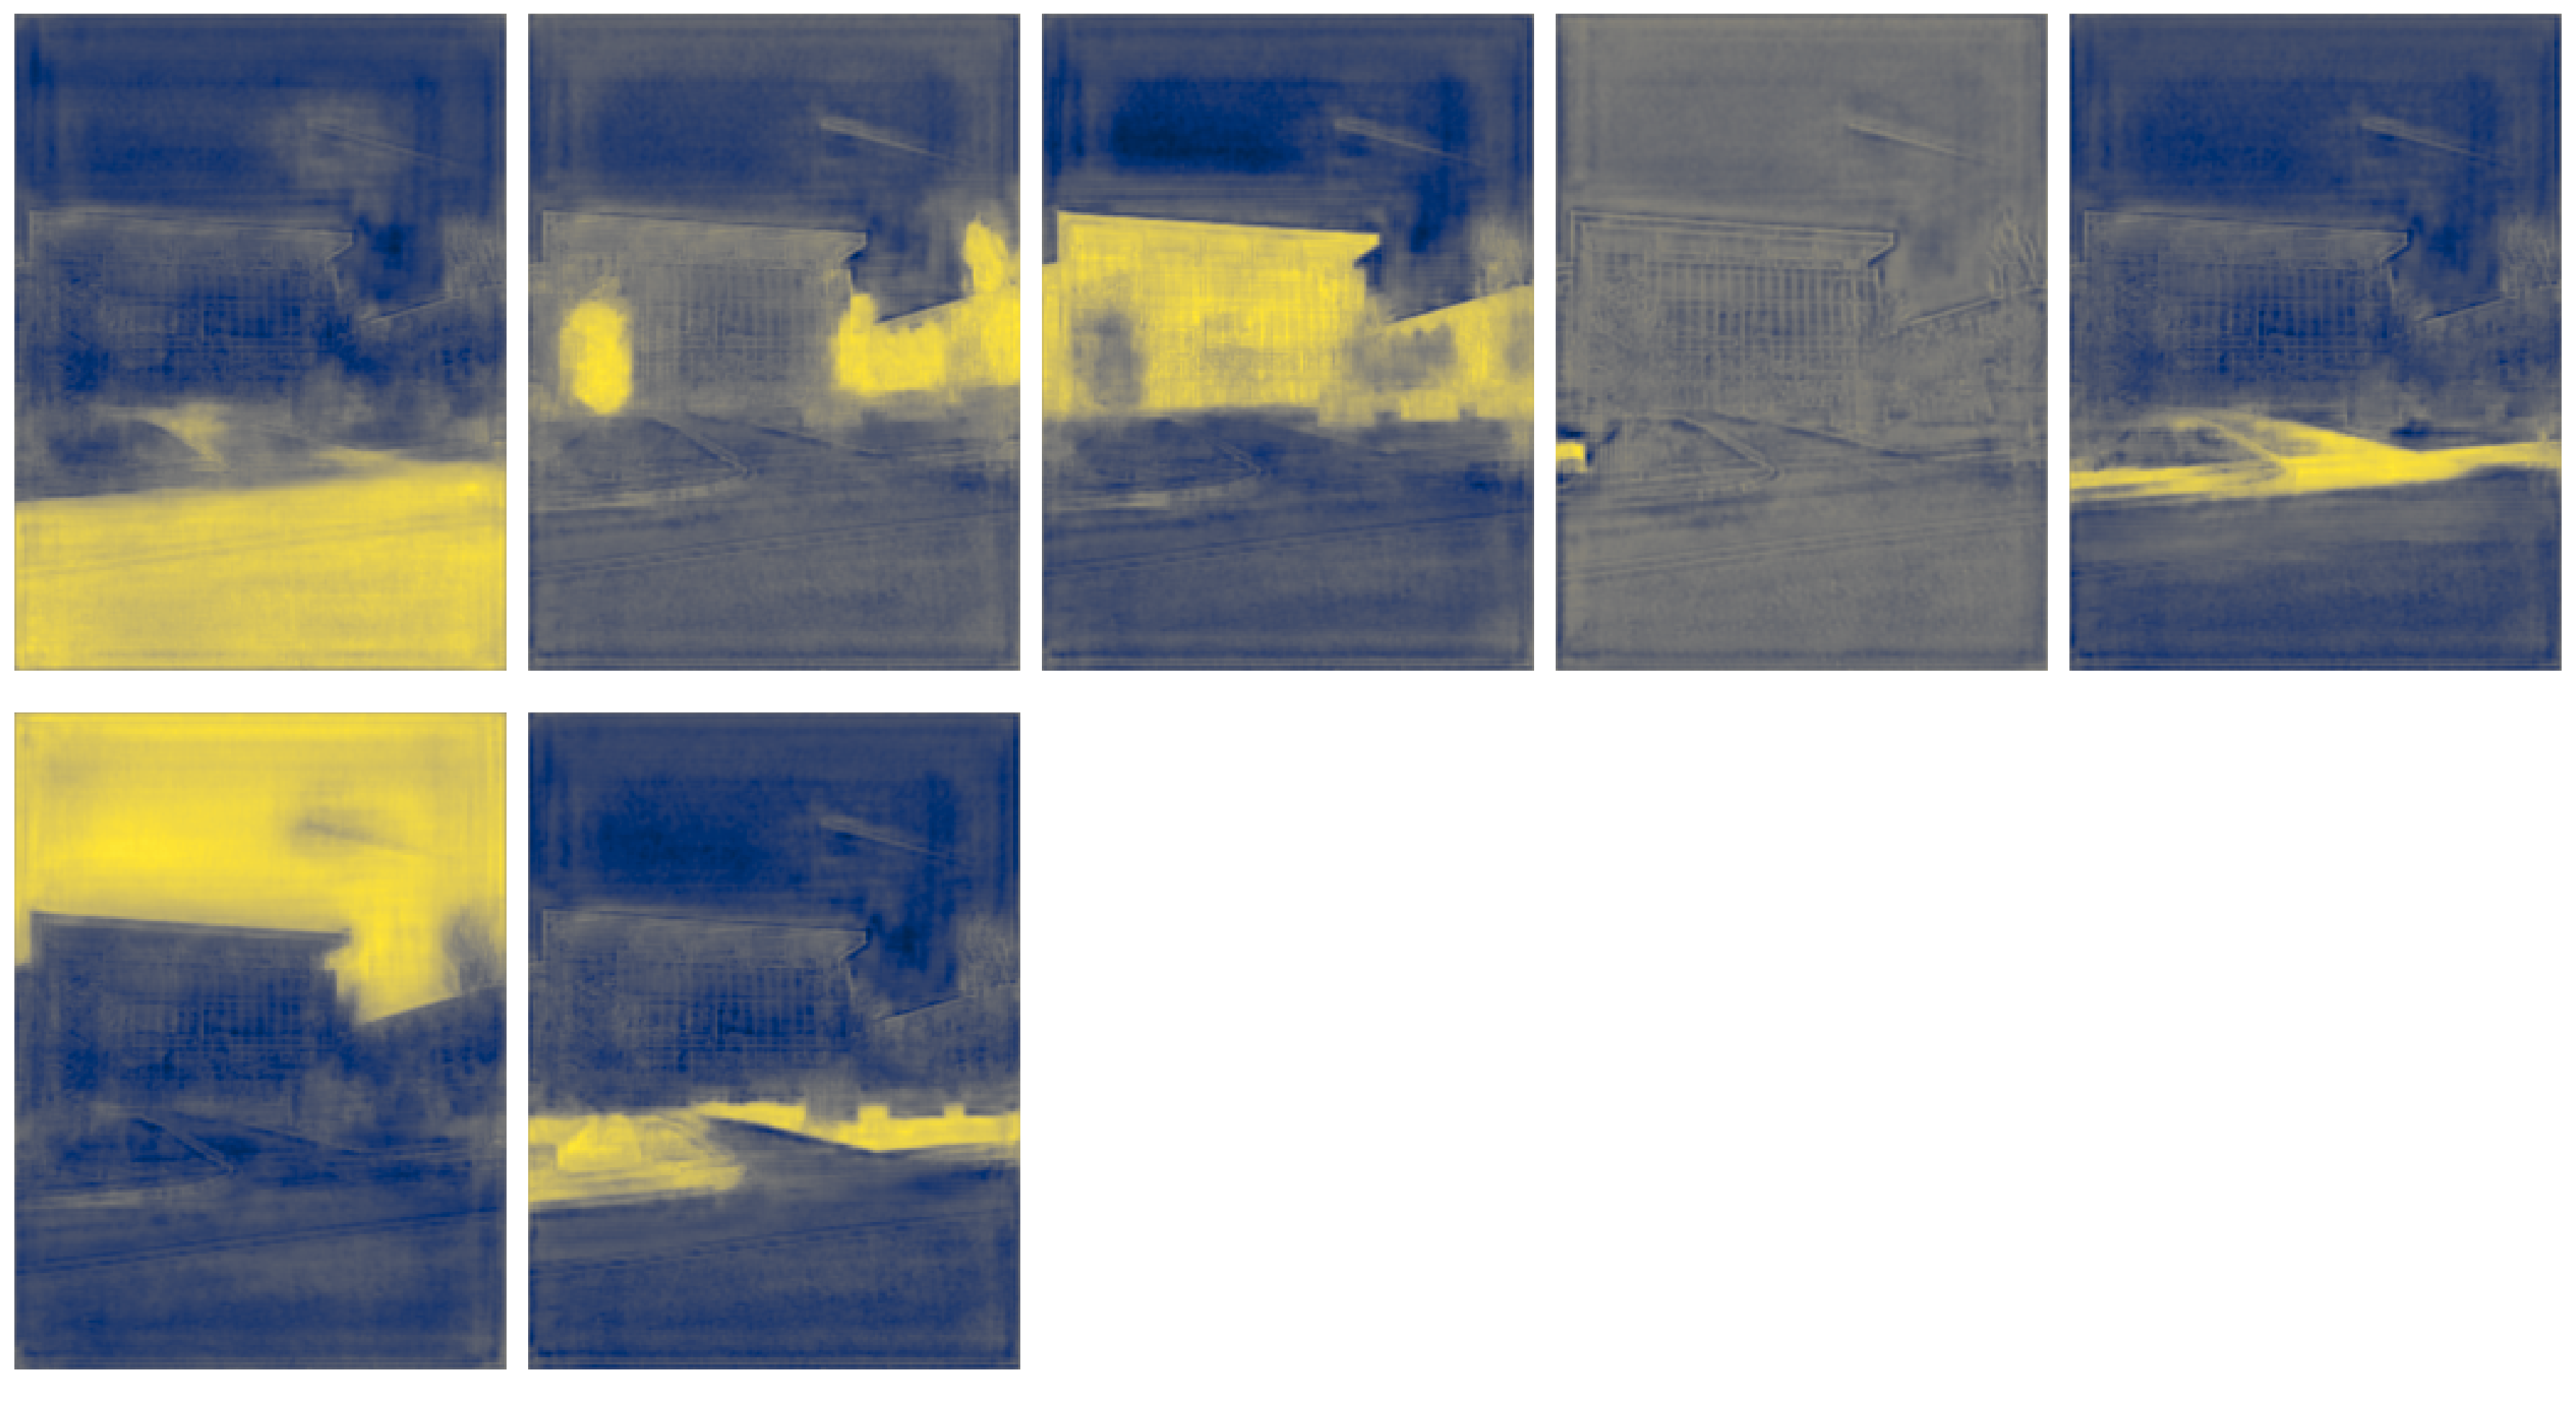

In [25]:
# compute the scores, excluding the "no-object" class (the last one)
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.9

# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask, cmap="cividis")
    ax.axis('off')
fig.tight_layout()

Now that we have the individual masks, we can merge the predictions into a unified panoptic segmentation. We use DETR's postprocessor for that.



In [26]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

We can now do a simple visualization of the result

## Panoptic visualization using Detectron2

In this section we demonstrate how to obtain a better looking visualization by leveraging Detectron2's plotting utilities.

In [27]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu118
True


In [28]:
import detectron2
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Finally, we visualize it

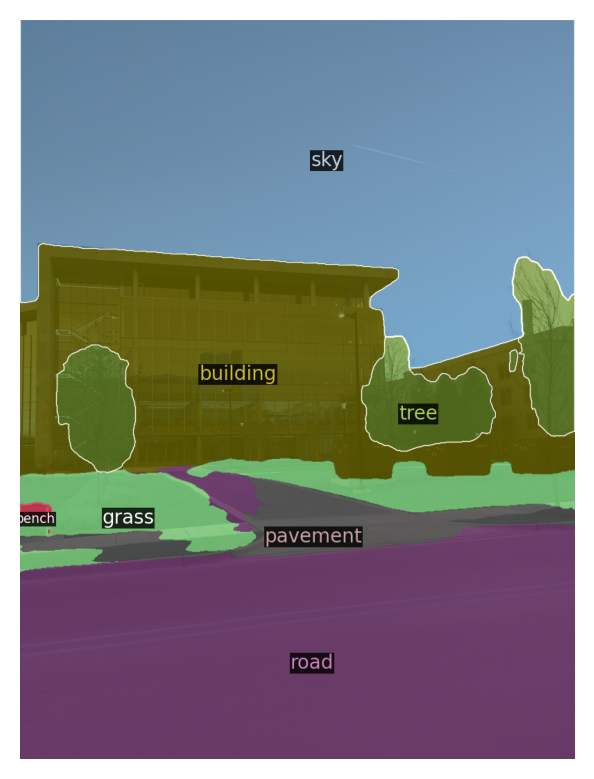

In [29]:
from copy import deepcopy
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")

for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
plt.imshow(v.get_image())
plt.axis('off')  # 关闭坐标轴
plt.show()

In [46]:
# 指定保存路径
save_dir = './DETR_result/image2/'
# 如果目录不存在，则创建
os.makedirs(save_dir, exist_ok=True)
# 初始化字典来存储每个类别的掩码
masks_dict = {}
category_names = {}

# 合并相同标签的掩码
for i, mask in enumerate(out["pred_masks"][keep]):
    if i >= len(segments_info):
        print(f"Warning: Skipping index {i} as it exceeds the length of segments_info")
        continue
    # 转换为二进制形式
    mask = (mask > 0.5).cpu().numpy().astype(np.uint8) * 255
    category_id = segments_info[i]['category_id']
    isthing = segments_info[i]['isthing']
    category_name = meta.thing_classes[category_id] if isthing else meta.stuff_classes[category_id]
    if category_id not in masks_dict:
        masks_dict[category_id] = mask
    else:
        masks_dict[category_id] = np.maximum(masks_dict[category_id], mask)
    category_names[category_id] = category_name
# 获取排序后的类别标签
sorted_category_ids = sorted(masks_dict.keys())
# 保存合并后的掩码并输出图片类别文件
image_categories_file = os.path.join(save_dir, 'image_categories.txt')
with open(image_categories_file, 'w') as f:
    for category_id in sorted_category_ids:
        merged_mask = masks_dict[category_id]
        mask_img = Image.fromarray(merged_mask)
        mask_img.save(os.path.join(save_dir, f'mask_class_{category_id}.png'))
        category_name = category_names[category_id]
        f.write(f'Label ID: {category_id}, Category: {category_name}\n')
print(f"Files saved to: {save_dir}")

Files saved to: ./DETR_result/image5/
